In [1]:
from source.metrics import DeputiesNetwork
from source.utils import *

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ANO_INICIO = 2019
ANO_FIM = 2024

# Análise das redes e os resumos de discursos

Esse Jupyter Notebook é para realizar a análise das redes de deputados e reconhecer padrões que possam ser explicados e entendidos pelos resumos dos discursos. Esses padrões podem explicar a movimentação política de partidos e/ou espectro políticos inteiros.  

Três tipos de análises serão feitas:  
- __Análise Qualitativa__: Uma análise visual dos plots das redes de deputados, será feita para pré identificação de padrões em destaque para direcionar a próxima análise;
- __Análise Quantitativa__: Uma análise numérica dos dados da rede para comprovar(ou não) as hipóteses da primeira análise;
- __Análise Textual__: Uma análise dos resumos gerados pelo LLM para compreender os padrões encontrados nas análise anteriores dando significado e causa para padrões identificados.

As duas primeiras análises serão prcurarão identificar Partidos e Comunidades __"Em Destaque"__: 
- Partidos de um mesmo espectro político ou posição em relação ao governo que estão visualmente e/ou numéricamente distantes ou isolados;
- Comunidades diferentes que representam um mesmo espectropolítico ou posição ao governo. 

Além disso será feita uma análise cronológica identificando aproximações e/ou isolamento de partidos, fusão e/ou surgimento de novas comunidades

## Análise preliminar da quantida de votações

In [3]:
def get_total_votacoes():
    total_votacoes = []
    for i in range(ANO_INICIO, ANO_FIM + 1):
        file_name = get_file_name(i)
        votacoes = load_json(file_name + '_votacoes')
        total_votacoes.append(len(votacoes))

    return total_votacoes

In [4]:
sum(get_total_votacoes())

3076

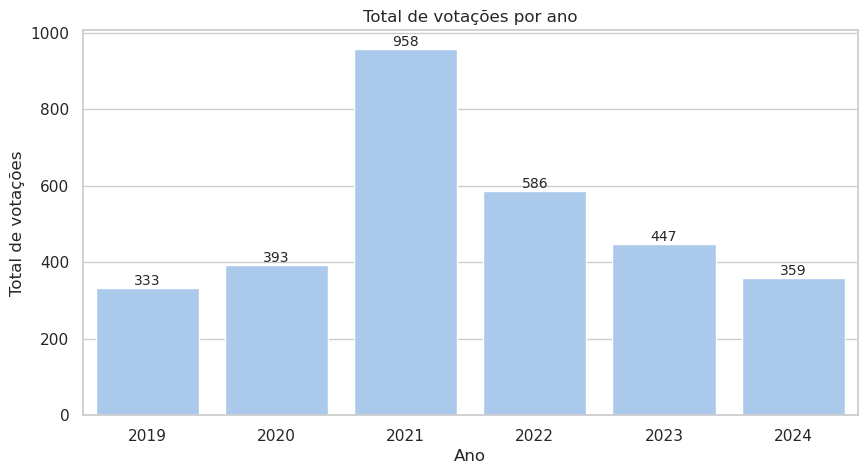

In [5]:
fig = plt.figure(figsize=(10, 5))

sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")

# Criar o gráfico de barras
ax = sns.barplot(x=list(range(ANO_INICIO, ANO_FIM + 1)), y=get_total_votacoes(), color="b")

# Adicionar os números no topo de cada barra
for bar in ax.containers[0]:
    altura = bar.get_height()
    if altura > 0:  # Apenas adiciona números se a altura for maior que zero
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # Posição X no centro da barra
            altura,  # Posição Y no topo da barra
            f'{int(altura)}',  # Texto a ser exibido
            ha='center', va='bottom', fontsize=10  # Centralizado horizontalmente e abaixo do topo
        )

# Configurações adicionais
plt.title('Total de votações por ano')
plt.ylabel('Total de votações')
plt.xlabel('Ano')
plt.show()


Com um Total de 3076 votações coletadas entre 2019 e 2024 vemos que o ano de 2021 tem muito mais votações que os demais anos. Isso pode se dar ao período de maior gravidade da pandêmia e o surgimento de diversas medididas, escandalos e investigações sendo feitas. Uma análise com recorte temporal maior pode comprovar melhor a hipótese.

## Contextualização da posição do governo no período

![linha do tempo](./imagens/linha_do_tempo.png)

O período de 2019 a 2024 consistem em um período marcado por dois governos, um de direita(Bolsonaro) e um de Esquerda(PT). Até metade do governo Bolsonaro a Direita se mantém na Presidência da Câmara, a partir desse momento a Centro Direita assume essa posição.
O periodo contém dois períodos de posse e um ano eleitoral, que influenciam a organização e parcerias partidárias. Além disso foi um período marcado pela Pandêmia de COVID-19 que chacoalhou o cenário político brasieliro. 

## Análises Anuais

In [6]:
def get_networks() -> dict[int, DeputiesNetwork]:
    return {
        2019: DeputiesNetwork(get_file_name(2019), initDistances= True),
        2020: DeputiesNetwork(get_file_name(2020), initDistances= True),
        2021: DeputiesNetwork(get_file_name(2021), initDistances= True),
        2022: DeputiesNetwork(get_file_name(2022), initDistances= True),
        2023: DeputiesNetwork(get_file_name(2023), initDistances= True),
        2024: DeputiesNetwork(get_file_name(2024), initDistances= True)
    }

In [7]:
networks = get_networks()

### 2019

In [8]:
year = 2019

#### Análise Qualitativa

![Partidos 2019](./imagens/2019_p.jpg)

Olhando os partidos vemos claramente uma distribuição entre partidos do bloco Governista e partidos do Bloco. O Bloco de Oposição aparenta estar mais coêso que o bloco Governista, tendo o PT em seu centro. O Bloco Governista aparenta ter duas regiões mais densas, uma aparentemente formada pelo PSL e NOVO e a outra formada por demais partidos de Direita e Centro.

![Comunidades 2019](./imagens/2019_c.jpg)

Olhando a rede pela comunidades claramente ve-se a organização dita ateriormente, com duas comunidades no Bloco Governista e uma comunidade no Bloco de Oposição. Também podemos ver um possível artefato.

#### Análise Qualitativa

In [9]:
networks[year].avarege_distance

1.2717181094322314

In [10]:
dep_por_partido = pd.Series({party: len(networks[year].parties[party]) for party in networks[year].parties})

In [11]:
community = pd.Series(networks[year].getPartiesInCommunity(1))

pd.DataFrame({
    'Deputados por partido': community,
    'Percentual do Partido na Comunidade':(community / dep_por_partido).dropna().mul(100).round(2),   
}).sort_values(by= 'Deputados por partido', ascending= False)

,Deputados por partido,Percentual do Partido na Comunidade
PT,52,100.00
PSB,29,93.55
PDT,28,100.00
PSOL,10,100.00
PCdoB,8,100.00
AVANTE,2,40.00
PODE,2,25.00
PROS,2,25.00
PV,2,66.67
PSD,2,6.90


In [12]:
community = pd.Series(networks[year].getPartiesInCommunity(0))

pd.DataFrame({
    'Deputados por partido': community,
    'Percentual do Partido na Comunidade':(community / dep_por_partido).dropna().mul(100).round(2),   
}).sort_values(by= 'Deputados por partido', ascending= False)

,Deputados por partido,Percentual do Partido na Comunidade
PSL,44,93.62
NOVO,8,100.00
CIDADANIA,7,87.50
PODE,6,75.00
PSDB,6,25.00
PATRIOTA,3,60.00
PL,2,6.45
PSC,2,28.57
PROS,2,25.00
AVANTE,2,40.00


In [13]:
community = pd.Series(networks[year].getPartiesInCommunity(2))

pd.DataFrame({
    'Deputados por partido': community,
    'Percentual do Partido na Comunidade':(community / dep_por_partido).dropna().mul(100).round(2),   
}).sort_values(by= 'Deputados por partido', ascending= False)

,Deputados por partido,Percentual do Partido na Comunidade
PL,29,93.55
PSD,27,93.10
PP,26,92.86
MDB,23,95.83
REPUBLICANOS,23,95.83
PSDB,18,75.00
DEM,16,94.12
PTB,9,100.00
SOLIDARIEDADE,9,100.00
PSC,4,57.14


In [14]:
community = pd.Series(networks[year].getPartiesInCommunity(3))

pd.DataFrame({
    'Deputados por partido': community,
    'Percentual do Partido na Comunidade':(community / dep_por_partido).dropna().mul(100).round(2),   
}).sort_values(by= 'Deputados por partido', ascending= False)

,Deputados por partido,Percentual do Partido na Comunidade
PSL,3,6.38


In [15]:
networks[year].fragmentation(networks[year].getCommunity(3))

0.27761094427761096

In [16]:
pd.Series(networks[year].getCommitiesFragmentation()).sort_values(ascending= False)

2    0.893986
0    0.859115
1    0.492230
3    0.277611
dtype: float64